In [1]:
import openml
import pickle
import pandas as pd
import numpy as np

from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
id = 24
dataset = openml.datasets.get_dataset(id)
dataset

OpenML Dataset
Name.........: mushroom
Version......: 1
Format.......: ARFF
Upload Date..: 2014-04-06 23:21:11
Licence......: Public
Download URL.: https://api.openml.org/data/v1/download/24/mushroom.arff
OpenML URL...: https://www.openml.org/d/24
# of features: None

# Data Preparation and Cleaning

In [3]:
df = dataset.get_data()[0]

In [4]:
df.shape

(8124, 23)

In [5]:
columns = [x.replace("-", "_") for x in df.columns]
columns = [x.replace("%3F", "") for x in columns]

In [6]:
df.columns = columns

# Feature mapping

Please refer to README for mapping details

In [7]:
features = {
    'cap_shape': {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken'},
    'cap_surface': {'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'},
    'cap_color': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p': 'pink', 
                  'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'bruises': {'t': 'bruises', 'f': 'no'},
    'odor': {'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty', 
             'n': 'none', 'p': 'pungent', 's': 'spicy'},
    'gill_attachment': {'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'},
    'gill_spacing': {'c': 'close', 'w': 'crowded', 'd': 'distant'},
    'gill_size': {'b': 'broad', 'n': 'narrow'},
    'gill_color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green', 
                   'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk_shape': {'e': 'enlarging', 't': 'tapering'},
    'stalk_root': {'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs', 'r': 'rooted', '?': 'missing'},
    'stalk_surface_above_ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk_surface_below_ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk_color_above_ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 
                               'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk_color_below_ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 
                               'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'veil_type': {'p': 'partial', 'u': 'universal'},
    'veil_color': {'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'},
    'ring_number': {'n': 'none', 'o': 'one', 't': 'two'},
    'ring_type': {'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none', 
                  'p': 'pendant', 's': 'sheathing', 'z': 'zone'},
    'spore_print_color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green', 
                          'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'},
    'population': {'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered', 'v': 'several', 'y': 'solitary'},
    'habitat': {'g':'grasses', 'l':'leaves', 'm':'meadows', 'p':'paths', 'u':'urban', 'w':'waste', 'd':'woods'}
}


In [8]:
for key, value in features.items():
    df[key] = df[key].map(value)

In [9]:
# If mushroom is poisonous, then set it to 1
df['class'] = np.where(df['class']=="p", 1, 0)

In [10]:
def check_nulls_and_types(df):
    nulls_df = (df.isnull().sum()/ df.shape[0]*100).round(2).to_frame().rename(columns={0:'percentage_nulls'})
    types_df = df.dtypes.to_frame().rename(columns={0:'data_type'})
    rv = nulls_df.merge(types_df, left_index=True, right_index=True)
    return rv

check_nulls_and_types(df)

,percentage_nulls,data_type
cap_shape,0.00,category
cap_surface,0.00,category
cap_color,0.00,category
bruises,0.00,category
odor,0.00,category
gill_attachment,0.00,category
gill_spacing,0.00,category
gill_size,0.00,category
gill_color,0.00,category
stalk_shape,0.00,category


# Remove Features

- Given that more than 30% of the data is missing for `stalk_root`, I decided to drop the feature instead of imputing it with the move

- 


In [11]:
cols_to_keep = [x for x in df.columns if x not in ["stalk_root"]]

In [12]:

df = df[cols_to_keep].copy()

# Train/Validation/Test Split

In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.20, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)
print(len(df_train), len(df_val), len(df_test))
# Keep train copy for charts
df_train_c = df_train.copy()

4874 1625 1625


In [14]:
target = "class"

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

del df_train[target]
del df_val[target]
del df_test[target]

# Mutual Information Score

In [15]:
# Class seems Balanced
pd.Series(y_train).value_counts()

0    2531
1    2343
Name: count, dtype: int64

In [16]:
def mutual_info_score_fn(series, target=y_train):
    return np.round(mutual_info_score(series, target), 2)

In [17]:
# Top 10 Feature by Mutual Information
info_df = df_train.apply(mutual_info_score_fn).to_frame().rename(columns={0:"mutual_info_score"})
info_df.sort_values("mutual_info_score", ascending=False).head(10)

,mutual_info_score
odor,0.63
spore_print_color,0.33
gill_color,0.29
ring_type,0.21
stalk_surface_above_ring,0.20
stalk_surface_below_ring,0.19
gill_size,0.18
stalk_color_below_ring,0.17
stalk_color_above_ring,0.17
population,0.14


# Zoom-In: Top 5 Features

In [18]:
k = 5
top_k_features = info_df.sort_values("mutual_info_score", ascending=False).head(k).index.tolist()

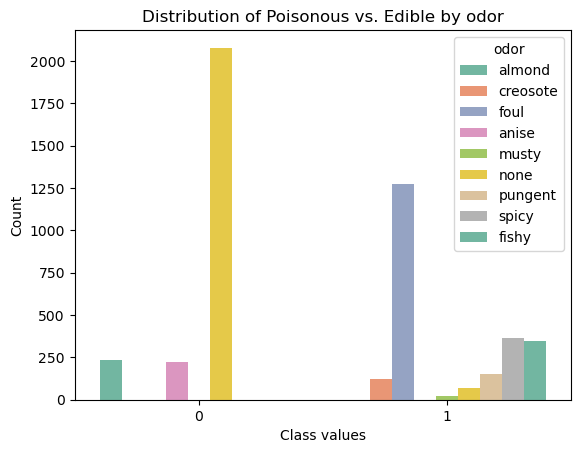

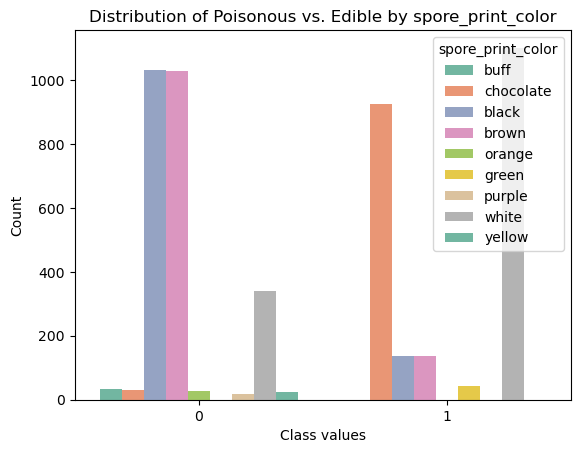

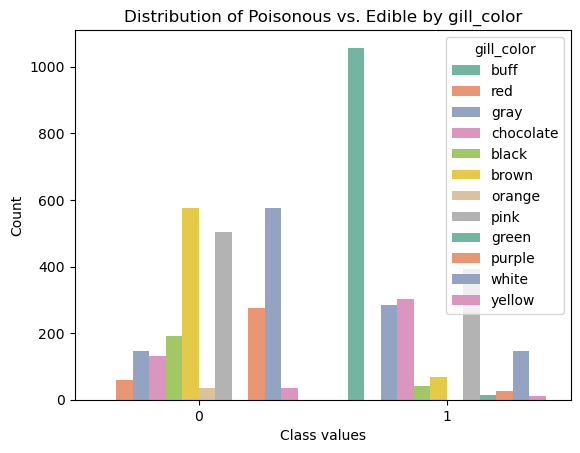

/tmp/ipykernel_11438/367744014.py:4: UserWarning: 
The palette list has fewer values (5) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=df_train_c, x='class', hue=col, palette=palette)


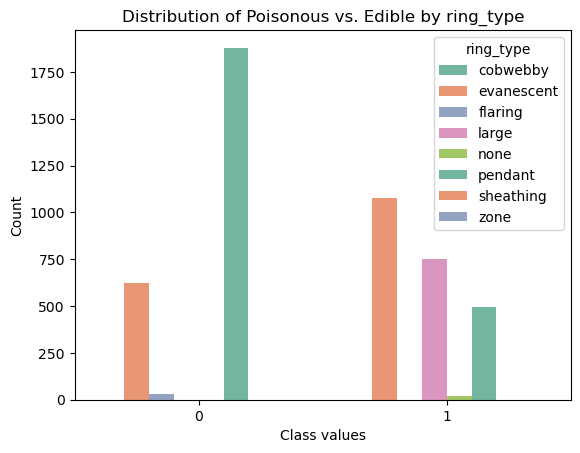

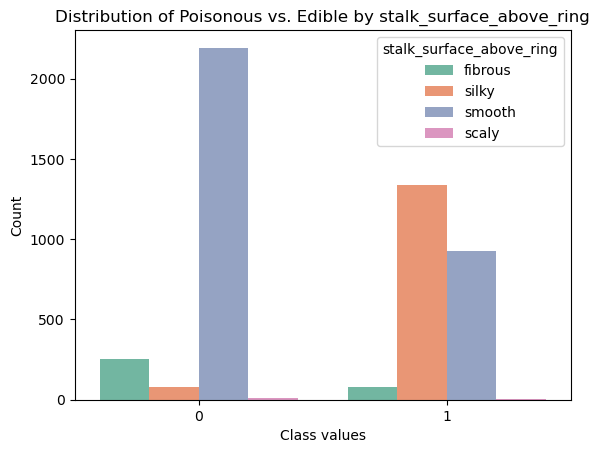

In [19]:

for col in top_k_features:
    unique_vals = df_train_c[col].nunique()
    palette = sns.color_palette("Set2", unique_vals)
    sns.countplot(data=df_train_c, x='class', hue=col, palette=palette)
    plt.xlabel('Class values')
    plt.ylabel('Count')
    plt.title(f'Distribution of Poisonous vs. Edible by {col}')
    plt.show()

# Brief Analysis

From the mutual information score, we learned that the top 5 features in the training dataset are: odor, spore_print_color, gill_color, ring_type and stalk_surface_above_ring

Looking at the distribution of these features by class, it is easy to see that attribures like `odor` clearly seem to clearlt distinguish poisonous vs. edible mushrooms.

It seems that mushrooms with fishy, spicy, etc. odors are more likely to be poisonous than mushrooms with almond-like or anise odors. 

In terms of color, the distribution shows that there is an overlap between edible and poisonous mushrooms.

# Model Selection

- I chose roc_auc_score as a metric to compare different models

In [20]:
def prepare_data(df):
    dicts = df.to_dict(orient='records')

    dv = DictVectorizer(sparse=True)
    X = dv.fit_transform(dicts)
    
    return X, dv

In [21]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [22]:
X_train, dv = prepare_data(df_train)

# 1. Logistic Regression

In [24]:
scores = []
for C in [0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = predict(df_val, dv, model)
    auc = roc_auc_score(y_val, y_pred)
    scores.append((C, auc))

In [26]:
df_logistic_scores = pd.DataFrame(scores, columns=["C", 'auc'])
df_logistic_scores

,C,auc
0,0.01,0.997573
1,0.10,0.999830
2,1.00,1.000000
3,10.00,1.000000
4,100.00,1.000000


In [27]:
# Max AUC
df_logistic_scores.iloc[df_logistic_scores['auc'].idxmax()]

C      1.0
auc    1.0
Name: 2, dtype: float64

# 2. Random Forest

In [28]:
X_train, dv = prepare_data(df_train)
X_val = dv.transform(df_val.to_dict(orient='records'))

In [29]:
scores = []

for n in range(10, 100, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=99, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [30]:
df_scores_hp1 = pd.DataFrame(scores, columns=['n_estimators', 'auc'])


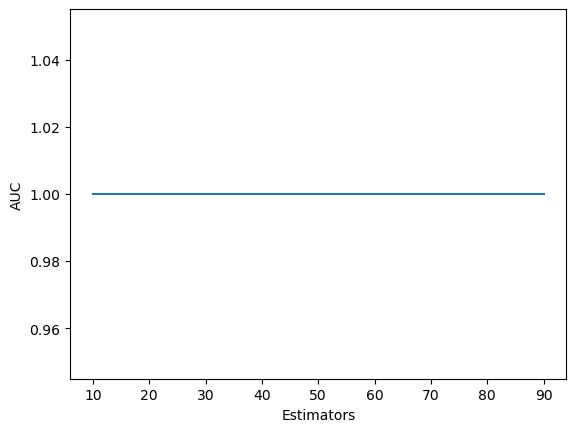

In [31]:
plt.plot(df_scores_hp1.n_estimators, df_scores_hp1.auc)
plt.xlabel('Estimators')
plt.ylabel('AUC')
plt.show()

In [32]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 100, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=99, 
                                    n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [33]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores_hp2 = pd.DataFrame(scores, columns=columns)

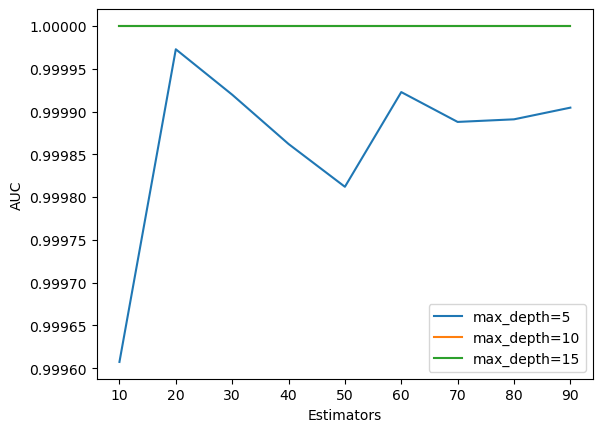

In [34]:
for d in [5, 10, 15]:
    df_subset = df_scores_hp2[df_scores_hp2.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)
    plt.ylabel('AUC')
    plt.xlabel("Estimators")

plt.legend()
plt.show()

In [35]:
max_depth = 10

In [36]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 100, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=99,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))


In [37]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores_hp3 = pd.DataFrame(scores, columns=columns)

In [38]:
df_scores_hp3.iloc[df_scores_hp3['auc'].idxmax()]

min_samples_leaf     1.0
n_estimators        10.0
auc                  1.0
Name: 0, dtype: float64

In [39]:
rf = RandomForestClassifier(n_estimators=10, max_depth=10, min_samples_leaf=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

1.0

In [40]:
feats = {} 
for feature, importance in zip(dv.feature_names_, rf.feature_importances_):
    feats[feature] = importance 
importances_df = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'gain'}).reset_index().rename(columns={'index':'features'})

In [41]:
top_k_features = importances_df.sort_values('gain',
                        ascending=False,
                        ).head(10).reset_index(drop=True)
top_k_features

,features,gain
0,odor=none,0.150114
1,odor=foul,0.088242
2,stalk_surface_below_ring=silky,0.077683
3,gill_size=broad,0.075131
4,ring_type=pendant,0.073450
5,bruises=bruises,0.063676
6,gill_color=buff,0.049336
7,odor=pungent,0.032582
8,stalk_shape=tapering,0.029967
9,population=several,0.026887


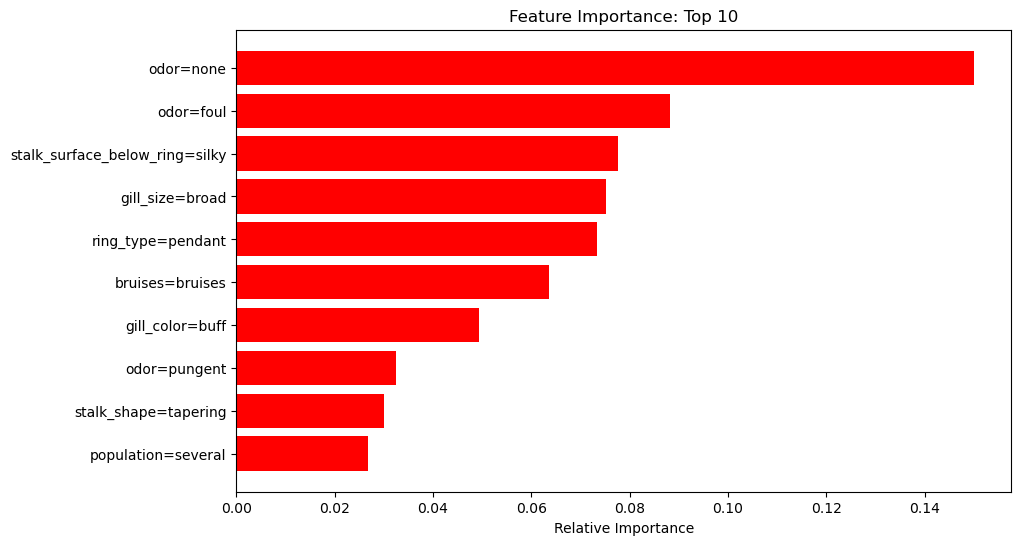

In [42]:
# Code adapted from https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
features = top_k_features['features']
importances = top_k_features["gain"]
indices = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.title('Feature Importance: Top 10')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


# Model Selection

- I decided to use Logistic Regression as it is a less complex models and achieves very similar results.

- Best value for C=1

In [43]:
y_full = df_full_train["class"].values
del df_full_train["class"]
X_full, dv = prepare_data(df_full_train)
model = LogisticRegression(solver='liblinear', C=1, max_iter=1000, random_state=42)
model.fit(X_full, y_full)
y_pred = predict(df_test, dv, model)
roc_auc_score(y_test, y_pred)


1.0

# Feature Importance from Logistic Regression

- Code adapted from [GeeksforGeeks](https://www.geeksforgeeks.org/understanding-feature-importance-in-logistic-regression-models/)


In [44]:
# Coefficients and Odds Ratios
coefficients = model.coef_[0]
odds_ratios = np.exp(coefficients)


# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'feature': dv.get_feature_names_out(),
    'coefficient': coefficients,
    'odds ratio': odds_ratios
})

In [45]:
feature_importance.sort_values(by='odds ratio', ascending=False)

,feature,coefficient,odds ratio
74,spore_print_color=green,4.258370,70.694635
49,odor=creosote,3.429668,30.866386
51,odor=foul,3.420297,30.578492
37,gill_size=narrow,2.260662,9.589437
54,odor=pungent,1.937244,6.939596
...,...,...,...
66,ring_type=flaring,-2.064771,0.126847
36,gill_size=broad,-2.115013,0.120632
48,odor=anise,-3.285531,0.037421
47,odor=almond,-3.298603,0.036935


In [46]:

with open('../artifacts/model.bin', 'wb') as f_out: # 'wb' means write-binary
    pickle.dump((dv, model), f_out)

In [51]:
df_test.to_parquet("../test_df.parquet")

In [17]:
df_test = pd.read_parquet("../artifacts/df_test.parquet").sample(5, random_state=42)

In [21]:
df_test.to_dict(orient='records')

[{'cap_shape': 'flat',
  'cap_surface': 'smooth',
  'cap_color': 'brown',
  'bruises': 'no',
  'odor': 'fishy',
  'gill_attachment': 'free',
  'gill_spacing': 'close',
  'gill_size': 'narrow',
  'gill_color': 'buff',
  'stalk_shape': 'tapering',
  'stalk_surface_above_ring': 'smooth',
  'stalk_surface_below_ring': 'smooth',
  'stalk_color_above_ring': 'white',
  'stalk_color_below_ring': 'white',
  'veil_type': 'partial',
  'veil_color': 'white',
  'ring_number': 'one',
  'ring_type': 'evanescent',
  'spore_print_color': 'white',
  'population': 'several',
  'habitat': 'paths',
  'class': 1},
 {'cap_shape': 'flat',
  'cap_surface': 'fibrous',
  'cap_color': 'white',
  'bruises': 'no',
  'odor': 'none',
  'gill_attachment': 'free',
  'gill_spacing': 'crowded',
  'gill_size': 'broad',
  'gill_color': 'chocolate',
  'stalk_shape': 'tapering',
  'stalk_surface_above_ring': 'fibrous',
  'stalk_surface_below_ring': 'smooth',
  'stalk_color_above_ring': 'white',
  'stalk_color_below_ring': 'w